In [ ]:
#!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
#!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv 

In [1]:
import os 

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [2]:
!pip install torchmetrics

     |████████████████████████████████| 329 kB 4.2 MB/s 


In [3]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 8.2 MB 6.6 MB/s 


In [4]:
from collections import Counter

import numpy as np

import pandas as pd

import pymorphy2

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1

from torchmetrics.functional import f1, recall

from tqdm.auto import tqdm

import nltk
from nltk.tokenize import TweetTokenizer

import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
positive = pd.read_csv('positive.csv', sep=';', header=None)[[3, 4]].rename(columns={3: 'text', 4: 'class'})
negative = pd.read_csv('negative.csv', sep=';', header=None)[[3, 4]].rename(columns={3: 'text', 4: 'class'})

In [7]:
negative['class'] = 0
negative.head()

,text,class
0,на работе был полный пиддес :| и так каждое за...,0
1,"Коллеги сидят рубятся в Urban terror, а я из-з...",0
2,@elina_4post как говорят обещаного три года жд...,0
3,"Желаю хорошего полёта и удачной посадки,я буду...",0
4,"Обновил за каким-то лешим surf, теперь не рабо...",0


In [8]:
data = pd.concat((negative, positive))
data.shape

(226834, 2)

Токенизируем и лемматизируем наши тексты

In [9]:
texts = data.text.values
tk = TweetTokenizer()
morph = pymorphy2.MorphAnalyzer()

vocab = Counter()
symb_vocab = Counter()
tokenized_texts = []

for text in texts:
  tok_text = [morph.parse(token)[0].normal_form for token in tk.tokenize(text) if token.isalpha()]  #  радикально поступаем со всеми не-словами, чтобы провести интересные эксперименты 
  vocab.update(tok_text)
  tokenized_texts.append(' '.join(tok_text))

  symbols = [s for s in tokenized_texts[-1]]
  symb_vocab.update(symbols)

In [10]:
freq_df = pd.DataFrame(data={'word': list(vocab.keys()), 'n_entries': list(vocab.values())})
symb_freq_df = pd.DataFrame(data={'symbol': list(symb_vocab.keys()), 'n_entries': list(symb_vocab.values())})

In [11]:
#  код честно позаимствован у Семена в последнем дз
print('Vocabulary size = ', len(vocab))

print('Доля слов, которые мы заменим на UNK:')

n_words = freq_df.n_entries.sum()

for threshold in np.arange(2, 12, 2):
    
    sub_df = freq_df[freq_df.n_entries < threshold]
    
    unk_freq = sub_df['n_entries'].sum() * 100 / n_words
    
    print('Порог отсечения - {}, доля UNK - {:.2f} %, слов в слове - {}, удалили - {} слов'.format(
        threshold, unk_freq, freq_df.shape[0] - sub_df.shape[0], sub_df.shape[0]))

Vocabulary size =  98247
Доля слов, которые мы заменим на UNK:
Порог отсечения - 2, доля UNK - 2.24 %, слов в слове - 42429, удалили - 55818 слов
Порог отсечения - 4, доля UNK - 3.98 %, слов в слове - 23863, удалили - 74384 слов
Порог отсечения - 6, доля UNK - 5.11 %, слов в слове - 17439, удалили - 80808 слов
Порог отсечения - 8, доля UNK - 5.98 %, слов в слове - 14082, удалили - 84165 слов
Порог отсечения - 10, доля UNK - 6.70 %, слов в слове - 11966, удалили - 86281 слов


In [12]:
print('Symbol vocabulary size = ', len(symb_vocab))

print('Сколько символов мы уберем:')

n_symb = symb_freq_df.n_entries.sum()

for threshold in np.arange(2, 15, 2):
    
    sub_df = symb_freq_df[symb_freq_df.n_entries < threshold]
    
    unk_freq = sub_df['n_entries'].sum() * 100 / n_symb
    
    print('Порог отсечения - {}, символов в слове - {}, удалили - {} символов'.format(
        threshold, symb_freq_df.shape[0] - sub_df.shape[0], sub_df.shape[0]))

Symbol vocabulary size =  154
Сколько символов мы уберем:
Порог отсечения - 2, символов в слове - 105, удалили - 49 символов
Порог отсечения - 4, символов в слове - 82, удалили - 72 символов
Порог отсечения - 6, символов в слове - 78, удалили - 76 символов
Порог отсечения - 8, символов в слове - 75, удалили - 79 символов
Порог отсечения - 10, символов в слове - 74, удалили - 80 символов
Порог отсечения - 12, символов в слове - 73, удалили - 81 символов
Порог отсечения - 14, символов в слове - 73, удалили - 81 символов


Заменим на UNK те, слова, что встречаются только единожды, из символов уберем около половины (порог <5)

In [13]:
def filter_text(text, vocab):
  filtered_vocab = []
  new_text = []
  for word in text.split():
      if vocab[word] > 1:
          filtered_vocab.append(word)
          new_text.append(word)
      else:
          new_text.append('UNK')
  
  return new_text, filtered_vocab

filtered_texts = []
new_vocab = set()

for text in tokenized_texts:
  new_text, filtered_vocab = filter_text(text, vocab)
  new_vocab.update(filtered_vocab)
  filtered_texts.append(' '.join(new_text))

In [14]:
filtered_symb_vocab = set()

for symbol in symb_vocab:
    if symb_vocab[symbol] >= 5:
        filtered_symb_vocab.add(symbol)

In [15]:
token2id = {'PAD':0}

for token in new_vocab:
    token2id[token] = len(token2id)

token2id['UNK'] = len(token2id)
id2token = {i:token for token, i in token2id.items()}

symbol2id = {'PAD':0}

for symbol in filtered_symb_vocab:
    symbol2id[symbol] = len(symbol2id)

id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [16]:
tokenized_data = pd.DataFrame()
tokenized_data['text'] = filtered_texts
tokenized_data['target'] = data['class'].values

In [17]:
tokenized_data.head()

,text,target
0,на работа быть полный UNK и так каждый закрыти...,0
1,коллега сидеть рубиться в urban terror а я дол...,0
2,как говорить UNK три год ждать,0
3,желать хороший полёт и удачный посадка я быть ...,0
4,обновить за леший surf теперь не работать прос...,0


In [18]:
train_data, val_data = train_test_split(shuffle(tokenized_data, random_state=42), test_size=0.2)

In [19]:
# with open('tokenized_data.pkl', 'wb') as file:
#   pickle.dump(tokenized_data, file)

### Train Fasttext embeddings

In [ ]:
from gensim.models import FastText

ft_vector_size = 200
corpus = [text.split() for text in tokenized_data.text.values]
ft_model = FastText(size=ft_vector_size, window=3, min_count=2)
ft_model.build_vocab(sentences=corpus)
ft_model.train(sentences=corpus, total_examples=len(corpus), epochs=10)

In [ ]:
weights = np.zeros((len(token2id), ft_vector_size))
count = 0
for word, i in token2id.items():
    if word == 'PAD' or word == 'UNK':
        continue   
    try:
        weights[i] = ft_model.wv[word]    
    except KeyError:
      count += 1
      weights[i] = np.random.normal(0, 0.1, ft_vector_size)

In [106]:
# import pickle

# with open('ft_weights.pkl', 'rb') as file:
#   weights = pickle.load(file)

In [21]:
assert weights.shape[0] == len(token2id)

### Dataloaders

In [22]:
class TweetDatasetWords(Dataset):
    def __init__(self, dataset, token2id, device):
        self.dataset = dataset['text'].values
        self.token2id = token2id
        self.length = dataset.shape[0]
        self.target = dataset['target'].values
        self.device = device

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index].split()
        ids = torch.LongTensor([self.token2id[token] for token in tokens if token in self.token2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): 
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [23]:
class TweetDatasetWithSymbols(Dataset):
    def __init__(self, dataset, token2id, symbol2id, device):
        self.dataset = dataset['text'].values
        self.token2id = token2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['target'].values
        self.device = device

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index].split()
        symbols = list(self.dataset[index])
        word_ids = torch.LongTensor([self.token2id[token] for token in tokens if token in self.token2id])
        symbol_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        y = [self.target[index]]
        return word_ids, symbol_ids, y

    def collate_fn(self, batch): 
      word_ids, symbol_ids, y = list(zip(*batch))
      padded_word_ids = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symb_ids = pad_sequence(symbol_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_word_ids, padded_symb_ids, y

Два отдельных даталоадера для разных моделей

In [42]:
train_dataset_w = TweetDatasetWords(train_data, token2id, device)
train_sampler_w = RandomSampler(train_dataset_w)
train_iterator_w = DataLoader(train_dataset_w, collate_fn = train_dataset_w.collate_fn, sampler=train_sampler_w, batch_size=256)

val_dataset_w =  TweetDatasetWords(val_data, token2id, device)
val_sampler_w = SequentialSampler(val_dataset_w)
val_iterator_w = DataLoader(val_dataset_w, collate_fn = val_dataset_w.collate_fn, sampler=val_sampler_w, batch_size=256)

In [43]:
train_dataset_s = TweetDatasetWithSymbols(train_data, token2id, symbol2id, device)
train_sampler_s = RandomSampler(train_dataset_s)
train_iterator_s = DataLoader(train_dataset_s, collate_fn = train_dataset_s.collate_fn, sampler=train_sampler_s, batch_size=256)

val_dataset_s =  TweetDatasetWithSymbols(val_data, token2id, symbol2id, device)
val_sampler_s = SequentialSampler(val_dataset_s)
val_iterator_s = DataLoader(val_dataset_s, collate_fn = val_dataset_s.collate_fn, sampler=val_sampler_s, batch_size=256)

### Models

In [26]:
class CNN_words(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, use_dropout=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
      
        self.conv = nn.Conv1d(in_channels=80+80, out_channels=80, kernel_size=3, padding='same')

        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=80, out_features=1)
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()    

    def forward(self, text):
        embedded = self.embedding(text)
        embedded = embedded.transpose(1,2)

        feature_map_bigrams = self.relu(self.bigrams(embedded))
        feature_map_trigrams = self.relu(self.trigrams(embedded))

        if self.use_dropout:
          feature_map_bigrams = self.dropout(feature_map_bigrams)
          feature_map_trigrams = self.dropout(feature_map_trigrams)

        concatenated = torch.cat((feature_map_bigrams, feature_map_trigrams), axis=-2)

        feature_map_concat = self.conv(concatenated)

        if self.use_dropout:
          feature_map_concat = self.dropout(feature_map_concat)
        feature_map_concat = self.relu(feature_map_concat)

        pooling = feature_map_concat.max(2)[0]
        
        logits = self.hidden(pooling) 
        logits = self.out(logits)     
         
        return logits

In [39]:
class CNN_words_symbols(nn.Module):
    
    def __init__(self, words_vocab_size, symb_vocab_size, embedding_dim_words, embedding_dim_symbols, pretrained_weights, use_dropout=False, use_batchnorm=False):
        super().__init__()
        self.embedding_words = nn.Embedding(words_vocab_size, embedding_dim_words)
        self.embedding_words.from_pretrained(torch.tensor(pretrained_weights), freeze=True)
        self.hidden1 = nn.Linear(in_features=embedding_dim_words, out_features=30)
        self.relu = nn.ReLU()

        self.embedding_symbols = nn.Embedding(symb_vocab_size, embedding_dim_symbols)

        self.bigrams = nn.Conv1d(in_channels=embedding_dim_symbols, out_channels=80, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim_symbols, out_channels=80, kernel_size=3, padding='same')
      
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(p=0.5)

        self.use_batchnorm = use_batchnorm
        self.batchnorm = nn.BatchNorm1d(80, affine=False)
        self.hidden2 = nn.Linear(in_features=80+80+30, out_features=1)
        self.out = nn.Sigmoid()    

    def forward(self, words, symbols):
        embedded_words = self.embedding_words(words)
        embedded_words = torch.mean(embedded_words, axis=1)
        X = self.hidden1(embedded_words)
        if self.use_dropout:
          X = self.dropout(X)
        
        X = self.relu(X)

        embedded_symbols = self.embedding_symbols(symbols)
        embedded_symbols = embedded_symbols.transpose(1,2)
        feature_map_bigrams = self.relu(self.bigrams(embedded_symbols))
        feature_map_trigrams = self.relu(self.trigrams(embedded_symbols))

        if self.use_dropout:
          feature_map_bigrams = self.dropout(feature_map_bigrams)
          feature_map_trigrams = self.dropout(feature_map_trigrams)

        if self.use_batchnorm:
          feature_map_bigrams = self.batchnorm(feature_map_bigrams)
          feature_map_trigrams = self.batchnorm(feature_map_trigrams)


        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]

        feature_map_concat = torch.cat((pooling1, pooling2), 1)
        concat =  torch.cat((feature_map_concat, X), 1)   
        
        logits = self.hidden2(concat) 
        if self.use_dropout:
          logits = self.dropout(logits)
        logits = self.out(logits)

        return logits

###Training and evaluating

In [29]:
def run_train_val(train_loader, val_loader, model, optimizer, criterion, n_epochs):
  losses_train = []

  losses_eval = []
  f1s_eval = []

  for epoch in range(n_epochs):
      progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {} train'.format(epoch + 1))
      epoch_loss = 0
      model.train()  

      for i, batch in enumerate(train_loader): 
          optimizer.zero_grad() 

          ys = batch[-1]
          texts = batch[0]

          if isinstance(model, CNN_words_symbols):
              symbols = batch[1]
              preds = model(texts, symbols)
          else:
              preds = model(texts)
              
          loss = criterion(preds, ys)  
          loss.backward()   
          optimizer.step() 
          epoch_loss += loss.item() 

          if not (i + 1) % int(len(train_loader)/5):
              progress_bar.set_postfix(train_loss=epoch_loss/(i+1))

          progress_bar.update(len(ys))
      
      progress_bar.close()
      losses_train.append(epoch_loss / len(train_loader))

      progress_bar = tqdm(total=len(val_loader.dataset), desc='Epoch {} test evaluating'.format(epoch + 1))
      epoch_loss = 0
      epoch_metric = 0
      model.eval() 
      with torch.no_grad():
          for i, batch in enumerate(val_loader):   
              ys = batch[-1]
              texts = batch[0]

              if isinstance(model, CNN_words_symbols):
                symbols = batch[1]
                preds = model(texts, symbols)
              else:
                preds = model(texts)
              
              loss = criterion(preds, ys)     
              epoch_loss += loss.item()
              batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
              epoch_metric += batch_metric

              if not (i + 1) % int(len(val_loader)/5):
                progress_bar.set_postfix(val_loss=epoch_loss/(i+1), val_f1=(epoch_metric/(i+1)).cpu().numpy())

              progress_bar.update(len(ys))

      losses_eval.append(epoch_loss / len(val_loader))
      f1s_eval.append(epoch_metric / len(val_loader))
    
  return losses_train, losses_eval, f1s_eval      

In [58]:
def plot_losses(losses_train, losses_eval, f1s_eval):
  fig, ax = plt.subplots(2, figsize=(5, 10))
  ax[0].plot(losses_train)
  ax[0].plot(losses_eval)
  ax[0].set_title('BCE loss value')
  ax[0].set_ylabel('BCE loss')
  ax[0].set_xlabel('epoch')
  ax[0].legend(['train', 'val'], loc='upper right')
 
  ax[1].plot(f1s_eval)
  ax[1].set_title('f1 value')
  ax[1].set_ylabel('f1 value')
  ax[1].set_xlabel('epoch')
   
  plt.show()

In [66]:
model = CNN_words(len(token2id), 20, use_dropout=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss().to(device)
n_epochs = 20

losses_train, losses_eval, f1s_eval = run_train_val(train_iterator_w, val_iterator_w, model, optimizer, criterion, n_epochs)

Epoch 1 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 1 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 2 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 2 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 3 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 3 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 4 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 4 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 5 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 5 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 6 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 6 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 7 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 7 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 8 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 8 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 9 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 9 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 10 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 10 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 11 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 11 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 12 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 12 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 13 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 13 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 14 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 14 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 15 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 15 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 16 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 16 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 17 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 17 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 18 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 18 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 19 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 19 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 20 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 20 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

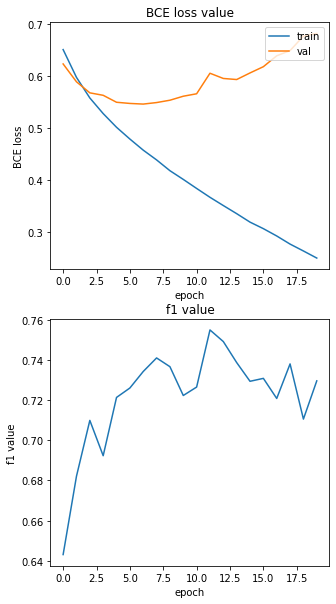

In [68]:
plot_losses(losses_train, losses_eval, f1s_eval)

In [69]:
model = CNN_words_symbols(len(token2id), len(symbol2id), ft_vector_size, 50, weights, use_dropout=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss().to(device)
n_epochs = 20

losses_train, losses_eval, f1s_eval = run_train_val(train_iterator_s, val_iterator_s, model, optimizer, criterion, n_epochs)

Epoch 1 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 1 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 2 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 2 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 3 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 3 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 4 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 4 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 5 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 5 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 6 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 6 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 7 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 7 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 8 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 8 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 9 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 9 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 10 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 10 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 11 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 11 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 12 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 12 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 13 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 13 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 14 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 14 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 15 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 15 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 16 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 16 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 17 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 17 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 18 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 18 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 19 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 19 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 20 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 20 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

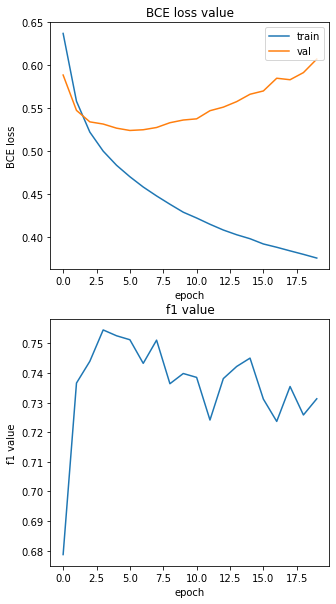

In [70]:
plot_losses(losses_train, losses_eval, f1s_eval)

### Вот мы и переобучились в обоих случаях, добавим дропаут

In [86]:
model = CNN_words(len(token2id), 20, use_dropout=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss().to(device)
n_epochs = 20

losses_train, losses_eval, f1s_eval = run_train_val(train_iterator_w, val_iterator_w, model, optimizer, criterion, n_epochs)

Epoch 1 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 1 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 2 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 2 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 3 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 3 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 4 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 4 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 5 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 5 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 6 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 6 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 7 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 7 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 8 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 8 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 9 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 9 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 10 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 10 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 11 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 11 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 12 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 12 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 13 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 13 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 14 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 14 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 15 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 15 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 16 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 16 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 17 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 17 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 18 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 18 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 19 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 19 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 20 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 20 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

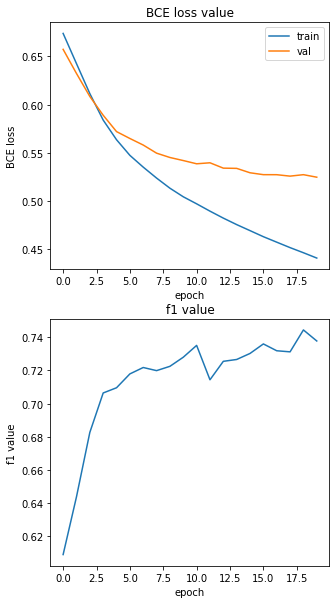

In [87]:
plot_losses(losses_train, losses_eval, f1s_eval)

In [64]:
model = CNN_words_symbols(len(token2id), len(symbol2id), ft_vector_size, 50, weights, use_dropout=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss().to(device)
n_epochs = 20

losses_train, losses_eval, f1s_eval = run_train_val(train_iterator_s, val_iterator_s, model, optimizer, criterion, n_epochs)

Epoch 1 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 1 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 2 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 2 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 3 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 3 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 4 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 4 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 5 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 5 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 6 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 6 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 7 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 7 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 8 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 8 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 9 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 9 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 10 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 10 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 11 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 11 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 12 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 12 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 13 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 13 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 14 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 14 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 15 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 15 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 16 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 16 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 17 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 17 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 18 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 18 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 19 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 19 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 20 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 20 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

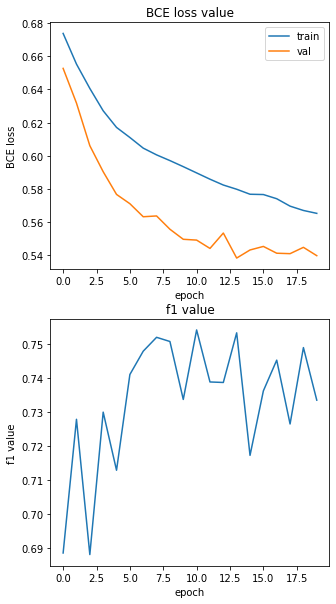

In [65]:
plot_losses(losses_train, losses_eval, f1s_eval)

Мы спаслись от переобучения, попробуем улучшить качество. Для первой модели попробуем увеличить размерность эмбеддинга до 50

In [84]:
model = CNN_words(len(token2id), 50, use_dropout=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss().to(device)
n_epochs = 20

losses_train, losses_eval, f1s_eval = run_train_val(train_iterator_w, val_iterator_w, model, optimizer, criterion, n_epochs)

Epoch 1 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 1 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 2 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 2 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 3 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 3 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 4 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 4 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 5 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 5 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 6 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 6 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 7 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 7 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 8 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 8 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 9 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 9 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 10 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 10 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 11 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 11 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 12 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 12 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 13 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 13 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 14 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 14 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 15 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 15 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 16 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 16 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 17 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 17 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 18 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 18 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 19 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 19 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 20 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 20 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

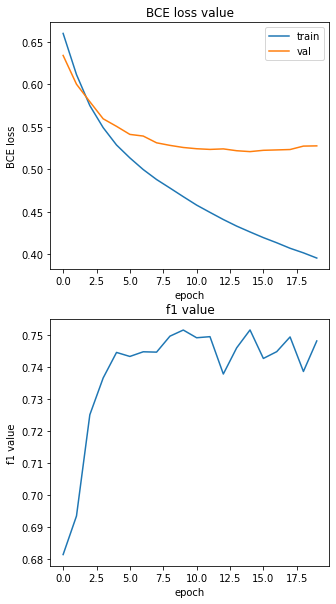

In [85]:
plot_losses(losses_train, losses_eval, f1s_eval)

Качество несильно, но поднялось Для второй модели попробуем уменьшить размерность (кажется, 50 для символов - многовато)

In [73]:
model = CNN_words_symbols(len(token2id), len(symbol2id), ft_vector_size, 20, weights, use_dropout=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss().to(device)
n_epochs = 20

losses_train, losses_eval, f1s_eval = run_train_val(train_iterator_s, val_iterator_s, model, optimizer, criterion, n_epochs)

Epoch 1 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 1 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 2 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 2 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 3 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 3 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 4 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 4 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 5 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 5 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 6 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 6 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 7 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 7 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 8 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 8 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 9 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 9 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 10 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 10 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 11 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 11 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 12 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 12 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 13 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 13 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 14 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 14 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 15 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 15 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 16 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 16 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 17 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 17 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 18 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 18 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 19 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 19 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

Epoch 20 train:   0%|          | 0/181467 [00:00<?, ?it/s]

Epoch 20 test evaluating:   0%|          | 0/45367 [00:00<?, ?it/s]

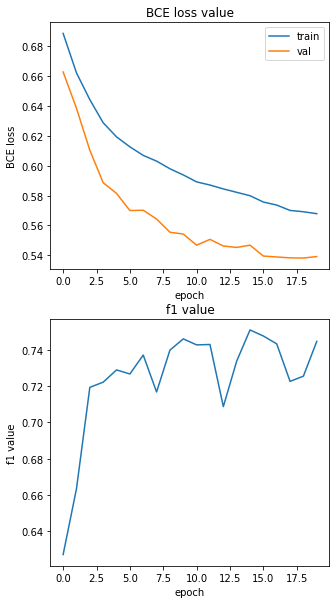

In [74]:
plot_losses(losses_train, losses_eval, f1s_eval)

Качество улучшилось несильно, но зато стало более стабильным. В целом модель без символов все равно лучше справляется. Попробуем проанализировать, где она ошибается

In [100]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in tqdm(enumerate(iterator)):   
            preds = model(texts)   
            for pred, gold, text in zip(preds, ys, texts):
              text = ' '.join([id2token[int(token)] for token in text if token !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [101]:
fp, fn, tp, tn = predict(model, val_iterator_w)

0it [00:00, ?it/s]

In [102]:
print('что правильно предсказываем:', tp[:100])


что правильно предсказываем: ['imagine we are уже как день не отпускать я', 'ахах я отстать от современность', 'первый падение правда не на улица а в падик сидеть ржа над себя', 'rt почти через час быть загадывать желание', 'rt ахахи как твой совесть в вид ангела и демон на плечо', 'эээма я тогда без шапка побыть dd', 'rt сдать экзамен по линейка на молодец', 'ну кто бы сомневаться ночной просмотр жеребьёвка и засыпание в не пройти даром я проспать первый пара', 'UNK гэж UNK мэддэг юм шиг яриада байгаа биздээ', 'rt мы пожалуйста шампанский и сухарик с чеснок и хрен d', 'смотреть как красиво за окно мороз и солнце день чудесный ещё ты дремать друг прелестный пора ай пойти оно', 'три слово который быть UNK мой будущий год сумасшествие путешествие и сила', 'какой ваш утро', 'хих я тоже нравиться орган в они UNK з спасать убивать иии я мама носка заставить одеть', 'немного запоздалый с успешный прибытие как дышаться в вольный UNK', 'rt прямо сейчас на майдан тысяча человек очень позитивный

In [103]:
print('ошибочно присваиваем негативную окраску:', fn[:100])

ошибочно присваиваем негативную окраску: ['нет у мой институт и у UNK программа такой альфа шанс от альфа банк к степух и возможность у они работать', 'никто UNK не нужный а то у я штука а девать некуда', 'в я уже вываливать на игра к рцоп', 'у они быть только печение', 'но я это я не на долго тут', 'да конечно ты быть гадить а я быть убирать', 'пакет порваться явно голова ещё большой заболеть', 'не знать слышать этот девочка я или нет но я за она болеть', 'поехать я бы на твой место дом остаться и UNK', 'не надо так всё серьёзно воспринимать есть более он не угрожать нет он не защищать', 'я тоже до ну я вообще час к туда собираться явно не ранний женя давать ненадолго много пить не быть', 'взять я на работа спрашивать что уметь блин деньга считать уметь', 'про журналистика и эксперт в она это пиздец извинить ой не ядерный физика совсем', 'давать не опаздывать я уже еда надо за учёба заплатить', 'спасибо ну не так как венгера всё таки хоть очко хотя обидно конечно', 'заболеть но прийти

In [105]:
print('ошибочно считаем положительно окрашенными:', fp[:100])

ошибочно считаем положительно окрашенными: ['rt но не быть унывать ведь у мы есть план ахи', 'визажист настолько уёбищный я накрасить что катя стести это UNK лицо и уже целый час', 'как это мучительный ждать следующий серия дневник вампир фанат понять', 'господин в вы тестировать свой продукт на iphone маленький чем карта UNK по секунда это нельзя пользоваться', 'rt эх если бы это быть ты рубиться бы в симс до утрааа', 'хотя нет я сценарий на новый год писать надо', 'вот блин это не ннада', 'а по секрет ребёнок мой час сон это нифига не нормально', 'а вообще я папа понимать он строгий потому что с год всё сам бабушка умереть дедушка не обращать на он внимание', 'только вот врезаться в машина не быть отличный идея пятничный вечер', 'причём хороший середина март', 'про то что он немногозадачный я не догадываться не разузнать этот вопрос и болезнь UNK рано проявиться', 'rt ну что они так на я смотреть', 'уля я дразнить не говорить что подарить', 'rt не просрать твит вы', 'ахахахи крутооо 

Кажется, что в некоторой степени это проблема предобработки - если в TP можно найти какие-то оставшиеся неудаленными слова-подсказки типа "ахах", то в FN после предобработки даже человеку сложно распознать изначальную окраску ('rt наверное стоить дать они минутка побыть вдвоём перед операция' и тд). Интересно при этом, что в FP много остается всяких вульгарных и нецензурных слов, которые могли бы быть хорошим признаком (типа 'нифига' в 'а по секрет ребёнок мой час сон это нифига не нормально'), но, видимо, они также часто могут встречаться в положительно окрашенных высказываниях